<a href="https://colab.research.google.com/github/mint-aguccim/Machine_Learning_Programming/blob/main/9%EC%A3%BC%EC%B0%A8/%EA%B3%BC%EC%A0%9C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error  # MSE 계산을 위해 import
import matplotlib.pyplot as plt

In [2]:
# 1. 데이터 로드

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alcohol_Sales.csv')
data = df['S4248SM144NCEN'].values.reshape(-1,1)

In [3]:
# 2. 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [8]:
# 3. 시퀀스 생성
window = 12  # 최근 12개월 → 다음달 예측
X, y = [], []
for i in range(len(data_scaled) - window):
    X.append(data_scaled[i:i+window])
    y.append(data_scaled[i+window])
X, y = np.array(X), np.array(y)

In [9]:
# 4. Train / Test 데이터 분리 (요청 사항)
split_point = int(len(X) * 0.8)  # 데이터의 80%를 학습용으로 사용

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [6]:
print(f"Total sequences: {len(X)}")
print(f"Train sequences: {len(X_train)}")
print(f"Test sequences: {len(X_test)}")

Total sequences: 313
Train sequences: 250
Test sequences: 63


In [10]:
# 5. LSTM 모델 (SimpleRNN은 LSTM 코드에 의해 덮어쓰여져 있었음)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window, 1)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 6. 모델 학습 (Train 데이터 사용)
# validation_data를 추가하여 테스트 데이터에 대한 손실도 함께 모니터링할 수 있습니다.
history = model.fit(X_train, y_train, epochs=50, batch_size=8,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0657 - val_loss: 0.0417
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 0.0143
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - val_loss: 0.0142
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0151
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0151
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0142
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0140
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0160
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0143
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0150
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - val_loss: 0.0137
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_l

In [12]:
# 7. 예측 (Test 데이터 사용)
pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


In [13]:
# 8. MSE 계산 (요청 사항)
# 정규화된 값으로 MSE 계산
mse_scaled = mean_squared_error(y_test, pred)
print(f"\nScaled MSE: {mse_scaled:.6f}")


Scaled MSE: 0.012210


In [14]:
# 원본 스케일 값으로 MSE 계산 (더 직관적인 평가)
y_test_inv = scaler.inverse_transform(y_test)
pred_inv = scaler.inverse_transform(pred)

In [15]:
mse_original = mean_squared_error(y_test_inv, pred_inv)
rmse_original = np.sqrt(mse_original) # RMSE (Root Mean Squared Error)

In [16]:
print(f"Original Scale MSE: {mse_original:,.2f}")
print(f"Original Scale RMSE: {rmse_original:,.2f}") # RMSE가 데이터의 단위와 같아 더 해석하기 좋습니다.

Original Scale MSE: 1,899,572.71
Original Scale RMSE: 1,378.25


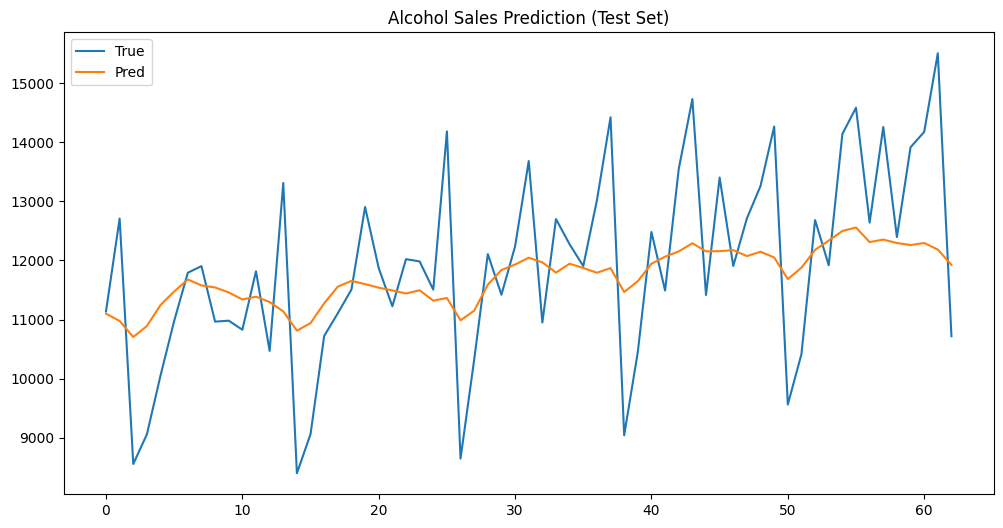

In [17]:
# 9. 시각화 (Test 데이터의 실제값 vs 예측값)
plt.figure(figsize=(12, 6))
plt.title('Alcohol Sales Prediction (Test Set)')
plt.plot(y_test_inv, label='True')
plt.plot(pred_inv, label='Pred')
plt.legend()
plt.show()